In [1]:
import numpy as np 
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
import json
import random

from tqdm import tqdm
import sys

import geopandas as gpd
from shapely.geometry import Point

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Import PyTorch
import torch
from torch import nn
import torch.optim as optim
import  torchvision.transforms as transforms

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import models, transforms

In [3]:
seed = 42  # Choose any number

# Set seed for PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)  # If using CUDA
torch.cuda.manual_seed_all(seed)  # If using multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set seed for NumPy and Python's random module
np.random.seed(seed)
random.seed(seed)

In [4]:
class MultiLabelDatasetRescale(Dataset):
    def __init__(self):
        # self.x_train, self.x_val, self.x_test, self.y_train, self.y_val, self.y_test = None, None, None, None, None, None
        self.mode = 'test'
        
         # Stack and convert to float32 tensor
        raw_images = torch.tensor(np.stack(df_2020_resampled['climatic_map'].values).astype(np.float32))  # shape: [N, H, W, C]
        # self.labels = torch.tensor(np.stack(df_2018_resampled['species_vector'].values).astype(np.float32))

        # Transpose to  [C, H, W] for PyTorch
        # raw_images = raw_images.permute(2, 0, 1)
        raw_images = raw_images.permute(0, 3, 1, 2)

                # === NORMALIZE EACH CHANNEL INDEPENDENTLY ===
        # These must match the order of your channels!

        #2018
        mins = torch.tensor([
            1.9000409841537476,          # gdd5
            0.9102739691734314,          # bio12d
            0.009359435178339481,         # swe
            -9.149993896484375,          # bio01d
            3.1500244140625,             # bio04d
            0.0,                         # cdd
            0.0,                         # fd
            1.0523613691329956,          # bio15d
            0.0,                         # scd
            0.0,                         # altitude
        ])

        maxs = torch.tensor([
            3858.301513671875, # gdd5
            21.650711059570312, #bio12d
            113.7122802734375, # swe
            10.45001220703125, #bio01d
            157.55001831054688, #bio04d
            8.0, #cdd
            362.0, # fd
            2.7762691974639893, #bio15d
            365.0, # scd
            2296.0, #altitude
        ])

        #2019

        # mins = torch.tensor([
        #     1.9000409841537476,          # gdd5
        #     0.7241,          # bio12d
        #     0.009359435178339481,         # swe
        #     -9.149993896484375,          # bio01d
        #     3.1500244140625,             # bio04d
        #     0.0,                         # cdd
        #     0.0,                         # fd
        #     1.0523613691329956,          # bio15d
        #     0.0,                         # scd
        #     0.0,                         # altitude
        # ])

        # maxs = torch.tensor([
        #     3858.301513671875, # gdd5
        #     21.650711059570312, #bio12d
        #     113.7122802734375, # swe
        #     10.45001220703125, #bio01d
        #     157.55001831054688, #bio04d
        #     8.0, #cdd
        #     362.0, # fd
        #     2.7762691974639893, #bio15d
        #     365.0, # scd
        #     2296.0, #altitude
        # ])

        # 2020

        # mins = torch.tensor([
        #     1.9000,          # gdd5
        #     0.1483,          # bio12d
        #     0,         # swe
        #     -9.149993896484375,          # bio01d
        #     3.1500,             # bio04d
        #     0.0,                         # cdd
        #     0.0,                         # fd
        #     0,          # bio15d
        #     0.0,                         # scd
        #     0.0,                         # altitude
        # ])

        # maxs = torch.tensor([
        #     3858.301513671875, # gdd5
        #     21.650711059570312, #bio12d
        #     113.7122802734375, # swe
        #     10.45001220703125, #bio01d
        #     157.55001831054688, #bio04d
        #     8.0, #cdd
        #     362.0, # fd
        #     2.7762691974639893, #bio15d
        #     365.0, # scd
        #     2296.0, #altitude
        # ])
        

        # Avoid division by zero (e.g., for crs with constant 0)
        ranges = maxs - mins
        ranges[ranges == 0] = 1  # Prevent division by zero

        # Apply scaling: (x - min) / (max - min)
        # self.images = (raw_images - mins.view(-1, 1, 1)) / ranges.view(-1, 1, 1)

        
        self.images = (raw_images - mins.view(1, -1, 1, 1)) / ranges.view(1, -1, 1, 1)
        self.idx = df_2020_resampled.index.to_list()
        
    def __len__(self):
        if self.mode == 'test':
            
            return len(self.images)


    def __getitem__(self, idx):
        if self.mode == 'test':
            sample = {'images': self.images[idx], 'index': self.idx[idx]}

        return sample

In [5]:
import torch.nn.functional as F
import torch.distributed as dist
import argparse

class CustomLoss(nn.Module):
    def __init__(self, loss_fn, args):
        super(CustomLoss, self).__init__()
        self.loss_fn = loss_fn
        self.weighted = args.weighted
        self.args = args
        if self.weighted:
            self.samples_per_cls = list(args.train_label_cnt.values())
            self.no_of_classes = args.num_classes

    def compute_weights(self, labels, beta=0.9999):
        effective_num = 1.0 - np.power(beta, self.samples_per_cls)
        weights = (1.0 - beta) / np.array(effective_num)
        weights = weights / weights.sum() * self.no_of_classes
        labels_one_hot = labels

        weights = torch.tensor(weights).float().to(self.args.device, non_blocking=True)
        weights = weights.unsqueeze(0)
        weights = weights.repeat(labels_one_hot.shape[0],1) * labels_one_hot
        
        return weights
    
    def forward_focal(self, logits, labels,alpha=0.999,gamma=2.0):
        p = torch.sigmoid(logits)
        ce_loss = F.binary_cross_entropy_with_logits(logits, labels, reduction="none")
        p_t = p * labels + (1 - p) * (1 - labels)
        loss = ce_loss * ((1 - p_t) ** gamma)
        
        if self.weighted:
            weights = self.compute_weights(labels)
            weights_t = weights * labels * alpha + (1 - labels) * (1 - alpha)
            weighted_loss = weights_t * loss
            focal_loss = weighted_loss.mean()
        
        else:
            alpha_t = alpha * labels + (1 - alpha) * (1 - labels)
            focal_loss = alpha_t * loss
            focal_loss = focal_loss.mean()
        
        return focal_loss

    
    def forward_bce(self, logits, labels):
        if self.weighted:
            weights = self.compute_weights(labels)
            bce_loss = F.binary_cross_entropy_with_logits(logits, labels, pos_weight = weights)
        else:
            bce_loss = F.binary_cross_entropy_with_logits(logits, labels)
        
        return bce_loss
    
    
    def forward_dice(self, logits, labels):
        p = torch.sigmoid(logits)
        smooth = 1.0
        intersection = (p * labels).sum(0)
        total = (p**2 + labels**2).sum(0)
        dice_loss = 1 - (intersection + smooth)/(total + smooth)
        
        return dice_loss.mean()
    
    
    def forward(self, logits, labels):
        if self.loss_fn == 'bce':
            return self.forward_bce(logits, labels)
        elif self.loss_fn == 'focal':
            return self.forward_focal(logits, labels)
        elif self.loss_fn == 'dice':
            return self.forward_dice(logits, labels)

In [6]:
class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet18, self).__init__()

        # Load Pretrained ResNet18
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        # Replace ReLU activations with inplace=False to avoid in-place modification issues
        # self.resnet.relu = nn.ReLU(inplace=False)

        # Modify the first convolutional layer to accept 11 channels instead of 3
        self.resnet.conv1 = nn.Conv2d(10, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Access layers up to the last block of layer4
        # self.features_conv = self.resnet.layer4[-1]  # Excluding the last block in layer4
        self.hook = self.resnet.layer3[-1].conv2.register_forward_hook(self.hook_fn)
        self.activations = None

        # Modify the final fully connected layer to match the number of classes     
        self.in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(self.in_features, num_classes)

        # Freeze all layers initially
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Placeholder for gradients
        self.gradients = None

    # Hook for capturing gradients during backward pass
    def activations_hook(self, grad):
        self.gradients = grad
        
    def hook_fn(self, module, input, output):
        # Store activations from the last convolutional layer
        self.activations = output
        
    # Forward pass through the network
    def forward(self, x):
        # Pass through the layers until the last convolutional block
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        # Register the hook on the output of the last convolutional layer (conv2 of the last block)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        # Register hook on the output of the last convolutional layer in layer4[1]
        x.requires_grad_()  # Enable gradient computation for this tensor
        h = x.register_hook(self.activations_hook)
        
        # Continue through the network
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        
        return x
    
    def get_embedding(self, x):
        # Forward pass up to avgpool
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)  # Shape: [batch_size, 2048]
        return x
    
    # Method to get the captured gradients
    def get_activations_gradient(self):
        return self.gradients

    # Method to get activations from the last convolutional layer (optional)
    def get_activations(self):
        return self.activations
    

In [16]:
with open('../data/species_counts_filtered_10_1991_2017.json', 'r') as f:
    class_counts_dict = json.load(f)

In [30]:
# Load the NumPy array from the pickle file
# with open('../models/old_no_norm/thresholds_focal_RESNET18_49_tss_2017.pkl', 'rb') as f:
#     loaded_thresholds = pickle.load(f)

with open('../models/thresholds_FOCAL_RESNET18_55_tss_1991-2017_full_v2.pkl', 'rb') as f:
    loaded_thresholds_RESNET = pickle.load(f)
global_threshold = np.mean(loaded_thresholds[np.isfinite(loaded_thresholds)])
global_threshold
with open('../models/2018/thresholds_BCE_53_tss_1991-2018.pkl', 'rb') as f:
    loaded_thresholds_BCE = pickle.load(f)

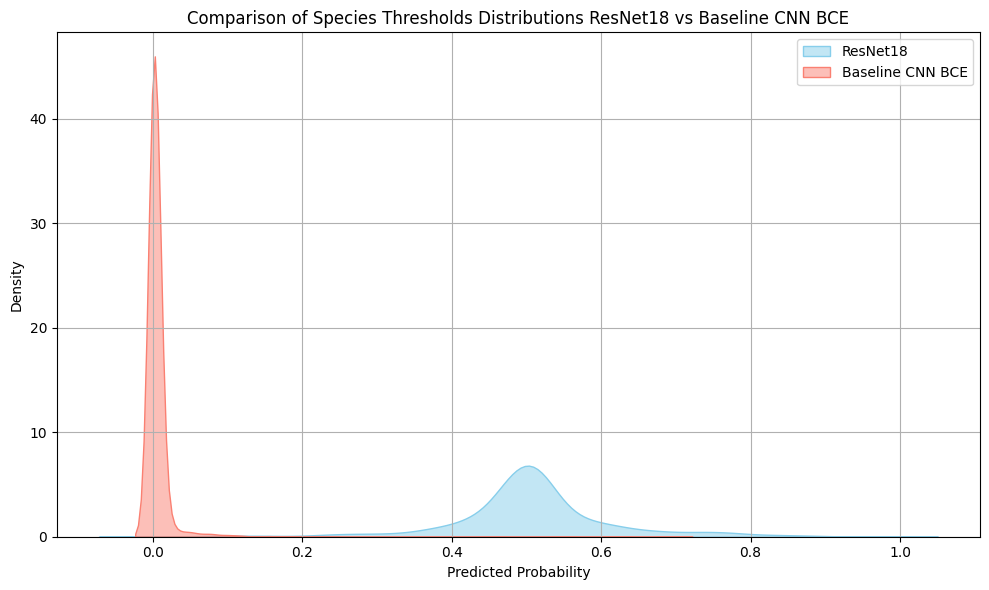

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example: model 1 and model 2 predictions (shape: n_samples x n_species)
# If tensors, convert to NumPy first
# preds1 = model1_preds.detach().cpu().numpy()
# preds2 = model2_preds.detach().cpu().numpy()

# Flatten all predictions into 1D arrays
probs_model1 = loaded_thresholds_RESNET.flatten()         # your first model
probs_model2 = loaded_thresholds_BCE.flatten()    # second model to compare

# Plot KDEs
plt.figure(figsize=(10, 6))
sns.kdeplot(probs_model1, label="ResNet18", fill=True, color="skyblue", alpha=0.5)
sns.kdeplot(probs_model2, label="Baseline CNN BCE", fill=True, color="salmon", alpha=0.5)

# Add labels and styling
plt.title("Comparison of Species Thresholds Distributions ResNet18 vs Baseline CNN BCE")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"../Images/Thresholds_distribution_comparison.png")
plt.show()

